[View in Colaboratory](https://colab.research.google.com/github/brucecmd/learn_gluon/blob/master/under_fitting_and_over_fitting2.ipynb)

In [0]:
import matplotlib.pyplot as plt

In [0]:
# Firstly, define a function to draw error loss picture
def draw(train_loss, test_loss):
    # draw the error curve
    plt.xlabel('epoch')
    plt.ylabel('Error')
    plt.plot(train_loss, c='r',label='train_loss')
    plt.plot(test_loss, c='b', label='test_loss')
    plt.legend()
    plt.show()

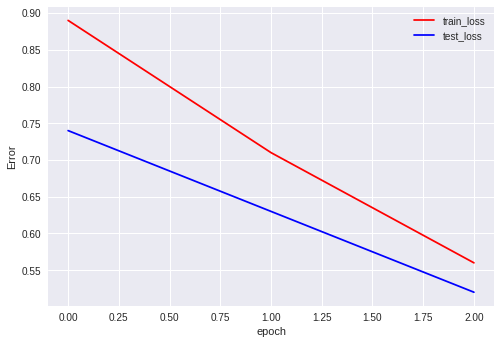

In [225]:
# test draw function
draw([0.89, 0.71, 0.56], [0.74, 0.63, 0.52])

In [0]:
from mxnet import nd, autograd
from mxnet.gluon import data as gdata

In [227]:
# begin make data
tmp_x = nd.random_normal(0,1,shape=(1000,1)) # shape must be (1000,1) instead of (1000,), or nd.power will fail
x = nd.concat(tmp_x, nd.power(tmp_x,2), nd.power(tmp_x,3))
true_w = [3.8, -2,7, 1.3]
true_b = 9.2
y = true_w[0] * x[:,0] + true_w[1] * x[:,1] + true_w[2] * x[:,2] + true_b
y += nd.random_normal(0,0.01,shape=y.shape)
print(x[:,:3])


[[  1.0621988    1.1282662    1.1984429 ]
 [ -0.67673695   0.4579729   -0.3099272 ]
 [ -0.5105827    0.26069468  -0.13310619]
 ...
 [ -2.21043      4.886      -10.800161  ]
 [  0.44725373   0.2000359    0.0894668 ]
 [ -0.71320325   0.5086589   -0.36277717]]
<NDArray 1000x3 @cpu(0)>


In [228]:
# prepare data_iter
def get_data_iter(x,y,train_ratio, batch_size):
    # split train and test by train_ratio
    train_len = int(len(x) * train_ratio)
    test_len = len(x) - train_len
    train_dataset = gdata.ArrayDataset(x[:train_len,:],y[:train_len])  # the dataset has not shape, so split data first, not in Dataloader function
    test_dataset = gdata.ArrayDataset(x[train_len:,:],y[train_len:])
    train_iter = gdata.DataLoader(train_dataset, batch_size, shuffle=True)
    test_iter = gdata.DataLoader(test_dataset, batch_size, shuffle=True)
    return train_iter, test_iter
train_iter, test_iter = get_data_iter(x,y,0.8,10)
for data,label in train_iter:
    print(data)
    print(label)
    break


[[-0.9537404   0.90962076 -0.8675421 ]
 [-0.7766605   0.6032015  -0.4684828 ]
 [ 0.2221017   0.04932917  0.01095609]
 [-0.5464985   0.29866058 -0.16321756]
 [-0.4806741   0.23104759 -0.11105859]
 [-0.58133644  0.33795205 -0.19646384]
 [ 1.1631876   1.3530054   1.5737991 ]
 [-0.3140912   0.09865329 -0.03098613]
 [-0.50487673  0.25490052 -0.12869334]
 [ 0.5314848   0.28247607  0.15013173]]
<NDArray 10x3 @cpu(0)>

[-2.3155062  1.7769837 10.02293    5.380248   6.1280823  4.9533978
 21.936453   7.5937114  5.8610973 11.705849 ]
<NDArray 10 @cpu(0)>


In [0]:
# define net
from mxnet.gluon import nn
from mxnet import init
net = nn.Sequential()
net.add(nn.Flatten())
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [0]:
# prepare loss function
from mxnet.gluon import loss as gloss
loss_func = gloss.L2Loss()

In [0]:
# prepare trainer
from mxnet import gluon
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.01})

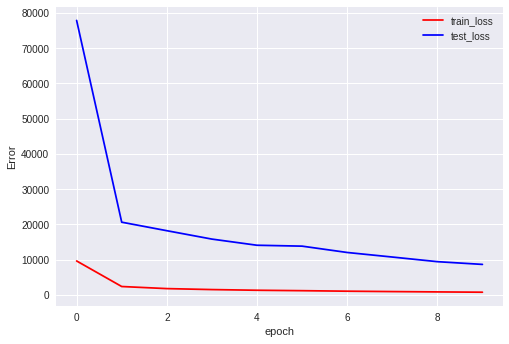

In [232]:
# because it is regression, use loss(from loss function) instead of accuracy function
# begin train and test
epochs = 10
batch_size = 10
train_len = int(len(x) * 0.1)
train_iter, test_iter = get_data_iter(x,y,0.1,batch_size)
train_loss_list = []
test_loss_list = []
for i in range(epochs):
    for data, label in train_iter:
        with autograd.record():
            y_hat = net(data)
            l = loss_func(y_hat, label)
        l.backward()
        trainer.step(batch_size)
    train_loss = loss_func(net(x[:train_len,:]), y[:train_len]).sum().asscalar()
    test_loss = loss_func(net(x[train_len:,:]), y[train_len:]).sum().asscalar()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
draw(train_loss_list, test_loss_list)    
    